# [Multilevel Modeling](https://en.wikipedia.org/wiki/Multilevel_model)
Idea: Decompose the sum of random numbers into its contributions

for a given set of $x_i$ and $a_{ik}$ with
$$x_i = \Sigma_{j=0}^n \Sigma_{k=1}^{m_j} a_{ik}y_{jk}$$ 
with
* $m_j$ being the number of contributers of layer j
* $y_{jk}$ being the k-th contribution of layer j
* $m_0 = 1$ by default
* $a_{ik} \in \{0, 1\}$
* $\Sigma a_{ik} = 1$ only one contributer per layer

calculate the Distributions $y_{k} \sim N(μ_{k}, σ_{k})$
Boundary conditions:
* $\Sigma _{k} μ_k = 0$ via $μ_{m_j} = -\Sigma_{k = 1}^{m_j-1} μ_{k}$

In [1]:
import numpy as np

# import os
import warnings
import matplotlib.pyplot as plt
import logging
import seaborn as sns
import pymc as pm
import arviz as az
import pytensor as pt
import pytensor  # inelegant :-(

# import pandas as pd
# import pymc.sampling_jax as sampling_jax
import nutpie

%matplotlib inline
plt.style.use("default")

# logging.basicConfig(format='%(message)s', level=logging.INFO)
warnings.filterwarnings("ignore", module="scipy")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.16.2


## Initialize the data

In [3]:
n_samples = 10000

## setup the individual random generators

In [4]:
def align_coefficients(coefs):
    """ensure that the average over all contributers per level is 0"""
    mem = []
    for lcoefs in coefs:
        avg = np.mean([m for (m, s) in lcoefs.values()])
        mem.append({k: (m - avg, s) for k, (m, s) in lcoefs.items()})

    return mem


def gen_contributer_coefficients(n_contributers, contributer_avg, contributer_sig):
    """creates for n_contributers the average and standard deviation
    Input:
    * n_contributers: list with number of influencers for each level
    * contributer_avg: average for the average of the influencers
    * contributer_sig: average for the stdev for the influencers (lognormal distribution)

    Output:
    Dictionary {level : { influencer: (mu, sigma)}} with the coefficients for every
    influencer in each level
    """
    assert n_contributers[0] == 1, "First level is allowed to have one contributer"
    return align_coefficients(
        [
            {
                i: (
                    np.random.normal(contributer_avg),
                    np.random.lognormal(contributer_sig),
                )
                for i in range(num)
            }
            for lvl, num in enumerate(n_contributers)
        ]
    )


def print_coefficients(contributer_coefficients):
    contributer_coefficients = align_coefficients(contributer_coefficients)
    for m, stage in enumerate(contributer_coefficients):
        for i, (mu, sig) in stage.items():
            print(f"Stage {m}: Contributer {i} mu={mu:.2f}, sig={sig:.2f}")

In [5]:
# easy as a start

cc_12 = [{0: (0, 5)}, {0: (1, 1), 1: (-1, 1)}]
cc_22 = [{0: (0, 5)}, {0: (1, 1), 1: (-1, 1)}, {0: (1, 1), 1: (-1, 1)}]
cc_27 = [
    {0: (0, 5)},
    {0: (1, 1), 1: (-1, 1), 2: (4, 1)},
    {0: (3, 1), 1: (-1, 1), 2: (-1, 1), 3: (-1, 1)},
]
cc_14 = [{0: (0, 5)}, {0: (0, 1), 1: (0, 1), 2: (0, 1), 3: (4, 2)}]
cc_343 = [
    {0: (0, 5)},
    {0: (0, 1), 1: (0, 1), 2: (0, 1), 3: (4, 2)},
    {0: (0, 1), 1: (0, 1), 3: (3, 2)},
]

In [6]:
print_coefficients(cc_343)

Stage 0: Contributer 0 mu=0.00, sig=5.00
Stage 1: Contributer 0 mu=-1.00, sig=1.00
Stage 1: Contributer 1 mu=-1.00, sig=1.00
Stage 1: Contributer 2 mu=-1.00, sig=1.00
Stage 1: Contributer 3 mu=3.00, sig=2.00
Stage 2: Contributer 0 mu=-1.00, sig=1.00
Stage 2: Contributer 1 mu=-1.00, sig=1.00
Stage 2: Contributer 3 mu=2.00, sig=2.00


## Create the Data

In [7]:
def gen_data(contributer_coefficients, n_samples):
    """generate random data.
    The first level defines the baseline that holds for all random numbers

    Inputs:
    * n_samples: number of samples
    * contributer_coefficients: dictionary with (mean,sig) per level per contributer

    Outputs:
    * data: array with the final number
    * contributers: matrix defining the contributers, first column is for the first level"""

    assert (
        len(contributer_coefficients[0]) == 1
    ), "Level 0 defines the baseline. It should have exactly one contributer"
    # data = np.random.normal(gen_avg, gen_sig, n_samples)
    data = np.zeros((n_samples,))
    contributers = np.zeros((n_samples, len(contributer_coefficients)))
    for lvl, cdict in enumerate(contributer_coefficients):
        print(f"creating level {lvl}")
        lvl_influencers = len(cdict)  # number of influencers in this level
        lvldata = np.zeros((n_samples, lvl_influencers))

        for i, (mu, sig) in cdict.items():
            lvldata[:, i] = np.random.normal(mu, sig, n_samples)

        selection = np.random.randint(low=0, high=lvl_influencers, size=(n_samples))
        contributers[:, lvl] = selection

        data += np.array([lvldata[row, col] for row, col in enumerate(selection)])
        # Note: The first level
    return data, contributers[:, 1:].astype(int)

# Modeling

use [Radon Analysis](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html) as reference

In [8]:
def run_model(model, **kwargs):
    print("start compilation")
    compiled_model = nutpie.compile_pymc_model(model)
    print("model is compiled")
    trace = nutpie.sample(compiled_model, **kwargs)
    return trace

In [9]:
def analyze(trace):
    az.summary(trace, round_to=2)
    az.plot_trace(
        trace,
        compact="true",
        chain_prop={"ls": "-"},
    )

    fig = plt.gcf()
    fig.tight_layout()
    plt.show()

In [10]:
def generate(n_samples, contributer_coefficients):
    if contributer_coefficients == 2:
        n_contributers = len(contributer_coefficients[1])
        print("ATTENTION: just for one level")
    else:
        n_contributers = [len(level) for level in contributer_coefficients][1:]

    data, contributers = gen_data(
        n_samples=n_samples, contributer_coefficients=contributer_coefficients
    )

    # contributers = contributers.squeeze(-1) # kill the first level - not needed
    return data, contributers, n_contributers

In [11]:
# generate the data
data0, contributers0, n_contributers0 = generate(
    n_samples=n_samples, contributer_coefficients=cc_14
)
data, contributers, n_contributers = generate(
    n_samples=n_samples, contributer_coefficients=cc_27
)

contributers0 = contributers0.squeeze(-1)  # for the 1 level version
n_contributers0 = n_contributers0[0]

creating level 0
creating level 1
creating level 0
creating level 1
creating level 2


In [12]:
with pm.Model() as model0:
    """
    simplest model
    converges for 2 contributers almost for more contributers
    """
    assert type(n_contributers0) is int, "only one level is possible"
    contributer_data_idx = pm.ConstantData(
        "contributer_data_idx", contributers0, dims="obs_id"
    )
    # datam = pm.ConstantData("data_idx", data0, dims="obs_id")

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    a_sigma = pm.Exponential("a_sigma", 1)

    # contributions
    con_sigmas = pm.Exponential("con_sigmas", 1, shape=n_contributers0)
    cons = pm.Normal("cons", mu=0, sigma=con_sigmas, shape=n_contributers0)

    # expected value
    # y_hat = pm.Deterministic("y_hat", a_mu + cons[contributer_data_idx], dims = "obs_id") #one dimension for every datapoint
    y_hat = a_mu + cons[contributer_data_idx]
    # Data
    value = pm.Normal("value", mu=y_hat, sigma=a_sigma, observed=data0)

c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [13]:
with pm.Model() as model0b:
    """
    without the baseline a_mu -> works perfectly
    
    """
    assert type(n_contributers0) is int, "only one level is possible"
    contributer_data_idx = pm.ConstantData(
        "contributer_data_idx", contributers0, dims="obs_id"
    )
    # datam = pm.ConstantData("data_idx", data0, dims="obs_id")

    # Priors
    # a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    a_sigma = pm.Exponential("a_sigma", 1)

    # contributions
    con_sigmas = pm.Exponential("con_sigmas", 1, shape=n_contributers0)
    cons = pm.Normal("cons", mu=0, sigma=con_sigmas, shape=n_contributers0)

    # expected value
    # y_hat = pm.Deterministic("y_hat", a_mu + cons[contributer_data_idx], dims = "obs_id") #one dimension for every datapoint
    y_hat = cons[contributer_data_idx]
    # Data
    value = pm.Normal("value", mu=y_hat, sigma=a_sigma, observed=data0)

c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [14]:
n = 5
samples = 10000

In [15]:
def data_faker(n, samples, mu_a=3, sig_a=5, sig_b=1):
    xdata = np.random.normal(mu_a, sig_a, samples)
    bdata = np.random.randint(low=0, high=n, size=(samples))
    mu = np.arange(0, n) - (n - 1) / 2
    for i, m in enumerate(mu):
        xdata += np.where(bdata == i, np.random.normal(m, sig_b, samples), 0)

    return xdata, bdata

In [16]:
xdata, bdata = data_faker(n, samples)

In [19]:
with pm.Model() as model:
    # Input data
    x = pm.Data("x", xdata, dims="obs_id")
    b = pm.Data("b", bdata, dims="obs_id")
    # baseline
    mu_a = pm.Normal("mu_a ", mu=0.0, sigma=10)
    sigma_a = pm.Exponential("sigma_a", 1)
    # level 1
    mu_c = pm.Exponential("mu_c", 1, shape=n)
    sigma_c = pm.Exponential("sigma_c", 1, shape=n)
    c = pm.Normal("c", sigma_c, shape=n)

    y_hat = mu_a + c[b]
    # y_hat = c[b] # --> this one runs stable

    # value
    value = pm.Normal("value", mu=y_hat, sigma=sigma_a, observed=x)

with pm.Model() as constrained_model:
    # Input data
    x = pm.Data("x", xdata, dims="obs_id")
    b = pm.Data("b", bdata, dims="obs_id")

    # baseline
    mu_a = pm.Normal("mu_a ", mu=0.0, sigma=10)
    sigma_a = pm.Exponential("sigma_a", 1)

    # level 1
    mu_c_raw = [pm.Exponential(f"mu_c_raw_{i}", 1) for i in range(n - 1)]
    # mu_c = pt.tensor.stacklists(mu_c_raw + [-pt.tensor.sum(mu_c_raw )])
    mu_c = pt.tensor.stacklists(
        mu_c_raw + [-pt.tensor.sum(pt.tensor.stacklists(mu_c_raw))]
    )
    sigma_c = pm.Exponential("sigma_c", 1, shape=n)

    c = pm.Normal("c", mu=mu_c, sigma=sigma_c, shape=n)

    y_hat = mu_a + c[b]

    # value
    value = pm.Normal("value", mu=y_hat, sigma=sigma_a, observed=x)

with pm.Model() as constrained_model_rp:
    # Input data
    x = pm.Data("x", xdata, dims="obs_id")
    b = pm.Data("b", bdata, dims="obs_id")

    # baseline
    mu_a = pm.Normal("mu_a ", mu=0.0, sigma=10)
    sigma_a = pm.Exponential("sigma_a", 1)

    # level 1
    mu_c_raw = [pm.Exponential(f"mu_c_raw_{i}", 1) for i in range(n - 1)]
    mu_c = pt.tensor.stacklists(mu_c_raw + [-pt.tensor.sum(mu_c_raw)])
    # mu_c = pytensor.tensor.stacklists(mu_c_raw + [-pt.tensor.sum(pytensor.tensor.stacklists(mu_c_raw ))])
    sigma_c = pm.Exponential("sigma_c", 1, shape=n)

    # reparametrization
    c_dist = pm.Normal("c_dist", mu=0, sigma=1, shape=n)
    c = pm.Deterministic("c", mu_c + sigma_c * c_dist)

    y_hat = mu_a + c[b]

    # value
    value = pm.Normal("value", mu=y_hat, sigma=sigma_a, observed=x)

with pm.Model() as constrained_model_rp:
    # Input data
    x = pm.Data("x", xdata, dims="obs_id")
    b = pm.Data("b", bdata, dims="obs_id")

    # baseline
    mu_a = pm.Normal("mu_a ", mu=0.0, sigma=10)
    sigma_a = pm.Exponential("sigma_a", 1)

    # level 1
    mu_c_raw = [pm.Exponential(f"mu_c_raw_{i}", 1) for i in range(n - 1)]
    mu_c = pt.tensor.stacklists(mu_c_raw + [-pt.tensor.sum(mu_c_raw)])
    # mu_c = pytensor.tensor.stacklists(mu_c_raw + [-pt.tensor.sum(pytensor.tensor.stacklists(mu_c_raw ))])
    sigma_c = pm.Exponential("sigma_c", 1, shape=n)

    # reparametrization
    c_dist = pm.Normal("c_dist", mu=0, sigma=1, shape=n)
    c = pm.Deterministic("c", mu_c + sigma_c * c_dist)

    y_hat = mu_a + c[b]

    # value
    value = pm.Normal("value", mu=y_hat, sigma=sigma_a, observed=x)

with pm.Model() as constrained_model_rp_det:
    """constrained model with reparametrization,
    trying to define the boundary condition via a deterministic variable (i.e. no c_dist)
    DOES NOT WORK
    """
    # Input data
    x = pm.Data("x", xdata, dims="obs_id")
    b = pm.Data("b", bdata, dims="obs_id")

    # baseline
    mu_a = pm.Normal("mu_a ", mu=0.0, sigma=10)
    sigma_a = pm.Exponential("sigma_a", 1)

    # level 1
    mu_c_raw = [pm.Exponential(f"mu_c_raw_{i}", 1) for i in range(n - 1)]
    mu_c = pt.tensor.stacklists(mu_c_raw + [-pt.tensor.sum(mu_c_raw)])
    # mu_c = pytensor.tensor.stacklists(mu_c_raw + [-pt.tensor.sum(pytensor.tensor.stacklists(mu_c_raw ))])
    sigma_c = pm.Exponential("sigma_c", 1, shape=n)

    # reparametrization
    c = pm.Deterministic(
        "c", mu_c + sigma_c * pm.Normal("c_dist", mu=0, sigma=1, shape=n)
    )

    y_hat = mu_a + c[b]

    # value
    value = pm.Normal("value", mu=y_hat, sigma=sigma_a, observed=x)

with pm.Model() as constrained_model_rp_zs:
    """constrained model with reparametrization and zero sum normal distribution"""
    # Input data
    x = pm.Data("x", xdata, dims="obs_id")
    b = pm.Data("b", bdata, dims="obs_id")

    # baseline
    mu_a = pm.Normal("mu_a ", mu=0.0, sigma=10)
    sigma_a = pm.Exponential("sigma_a", 1)

    # level 1
    sigma_c = pm.Exponential("sigma_c", 1, shape=n)

    # reparametrization is needed since ZSN has the same sigma for all dimensions
    c_dist = pm.ZeroSumNormal("c_dist", sigma=1, shape=n)
    c = pm.Deterministic("c", sigma_c * c_dist)

    y_hat = mu_a + c[b]

    # value
    value = pm.Normal("value", mu=y_hat, sigma=sigma_a, observed=x)

with pm.Model() as softmax_model:
    """constrained model with softmax. Good convergence, slightly different results wrt expectation"""
    # Input data
    x = pm.Data("x", xdata, dims="obs_id")
    b = pm.Data("b", bdata, dims="obs_id")

    # baseline
    mu_a = pm.Normal("mu_a ", mu=0.0, sigma=10)
    sigma_a = pm.Exponential("sigma_a", 1)

    # level 1
    sigma_c = pm.Exponential("sigma_c", 1, shape=n)

    # reparametrization is needed since ZSN has the same sigma for all dimensions
    c_dist = pm.Normal("c_dist", mu=0, sigma=1, shape=n)
    # mu_c = pm.Exponential("c_mu", 0, shape=n)

    c = pm.Deterministic("c", sigma_c * pt.tensor.special.softmax(c_dist))  # works
    # c = pm.Deterministic("c",  mu_c + sigma_c* pt.tensor.special.softmax(c_dist)) #Division by Zero Error

    y_hat = mu_a + c[b]

    # value
    value = pm.Normal("value", mu=y_hat, sigma=sigma_a, observed=x)

coords = {"group": np.arange(n)}
with pm.Model(coords=coords) as dirichlet_model:
    """constrained model with reparametrization and zero sum normal distribution"""
    # Input data
    x = pm.Data("x", xdata, dims="obs_id")
    b = pm.Data("b", bdata, dims="obs_id")

    # baseline
    mu_a = pm.Normal("mu_a ", mu=0.0, sigma=10)
    sigma_a = pm.Exponential("sigma_a", 1)

    # level 1
    sigma_c = pm.Exponential("sigma_c", 1, shape=n)

    mu_c_max = pm.Exponential("c_max", 1, shape=1)
    c_dist = pm.Dirichlet("c_dist", a=np.ones(n), dims="group")

    c = pm.Deterministic("c", mu_c_max * c_dist * sigma_c)

    y_hat = mu_a + c[b]

    # value
    value = pm.Normal("value", mu=y_hat, sigma=sigma_a, observed=x)

# Define coordinates for groups
coords = {"group": np.arange(n)}  # [0, 1, 2, 3, 4]
with pm.Model(coords=coords) as zweli_model:
    # Data containers
    bdata_shared = pm.Data("bdata_shared", bdata)  # Length: samples
    x_obs_data = pm.Data("x_obs_data", xdata)  # Length: samples

    # Prior for overall mean effect
    a_i = pm.Normal("a_i", mu=3, sigma=5)

    # Prior for group-specific weights (normalized to sum to 1)
    b_ij = pm.Normal("b_ij", mu=0, sigma=1, dims="group", initval=np.zeros(n))
    b_softplus = pt.tensor.softplus(b_ij)
    b_ij_binary = pm.Deterministic(
        "b_ij_binary", b_softplus / pt.tensor.sum(b_softplus)
    )

    # Prior for group-specific effects
    c = pm.Normal("c", mu=0, sigma=5, dims="group")

    # Expected value per data point
    b_ij_binary_i = b_ij_binary[bdata_shared]
    c_i = c[bdata_shared]
    x_i = a_i + b_ij_binary_i * c_i

    # Likelihood
    sigma_obs = pm.HalfNormal("sigma_obs", sigma=1)
    x_obs = pm.Normal("x_obs", mu=x_i, sigma=sigma_obs, observed=x_obs_data)

start compilation
model is compiled


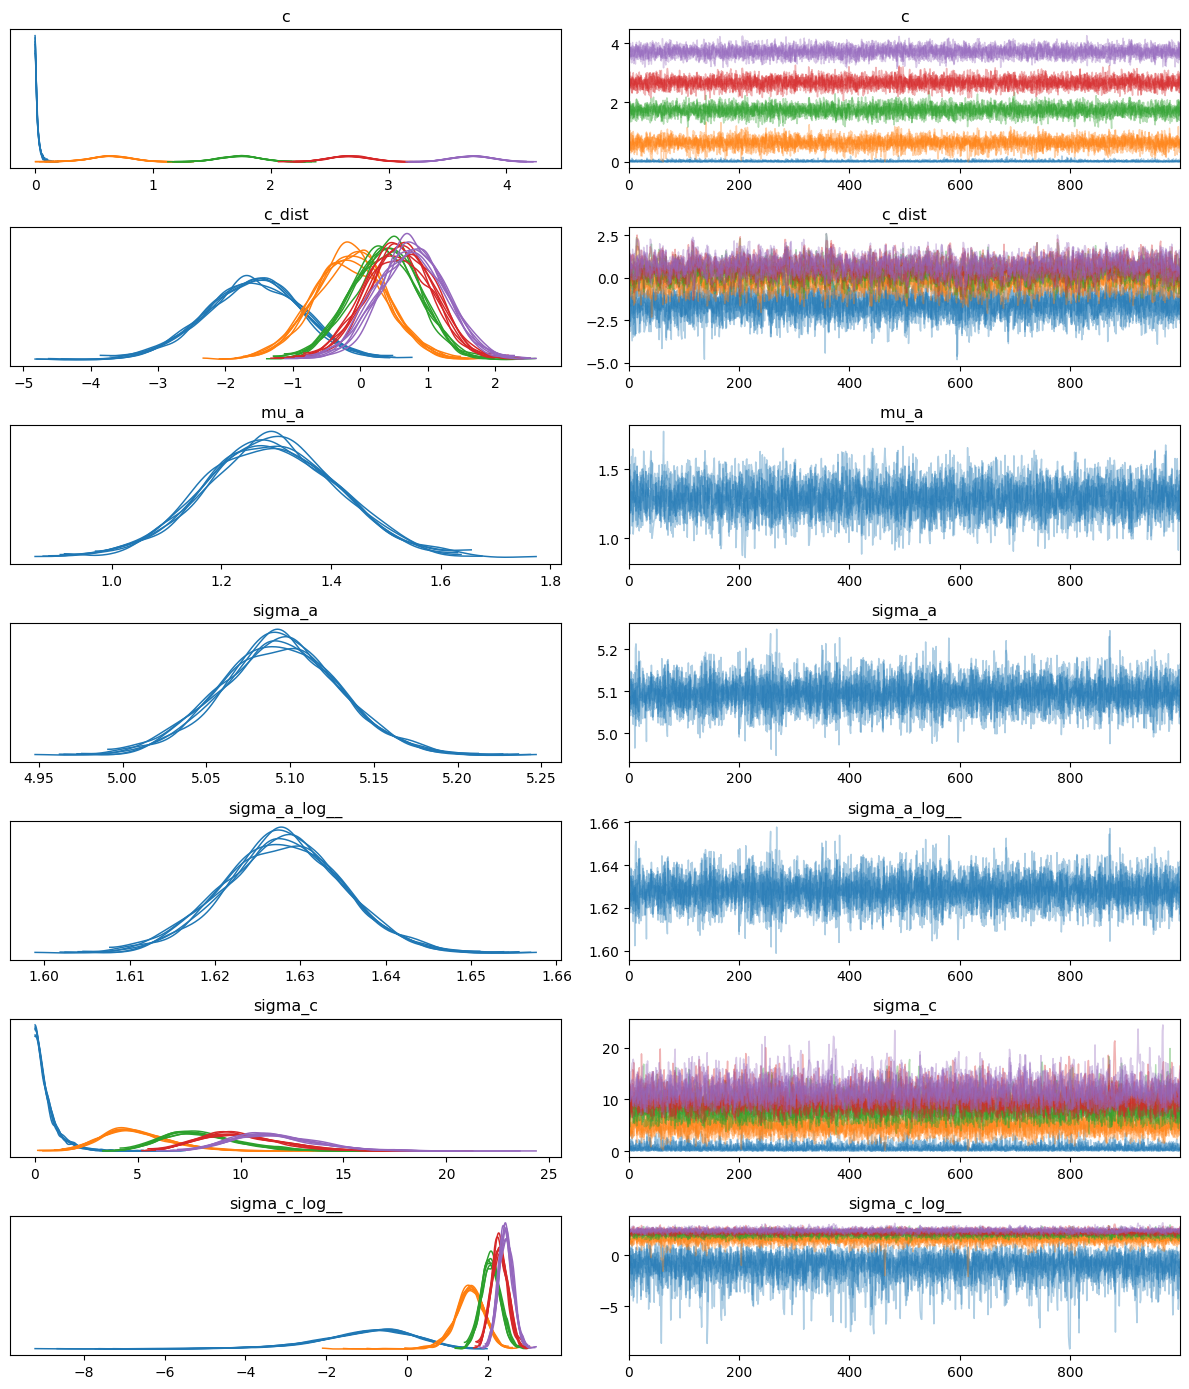

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
c[0]               0.02  0.02    0.00     0.06       0.00     0.00   4841.22   
c[1]               0.64  0.18    0.29     0.96       0.00     0.00   4032.15   
c[2]               1.73  0.17    1.41     2.05       0.00     0.00   5128.26   
c[3]               2.67  0.17    2.35     2.97       0.00     0.00   4655.88   
c[4]               3.71  0.17    3.41     4.03       0.00     0.00   4680.22   
c_dist[0]         -1.59  0.71   -2.97    -0.29       0.01     0.01   4436.93   
c_dist[1]         -0.16  0.54   -1.23     0.81       0.01     0.01   1659.73   
c_dist[2]          0.36  0.51   -0.61     1.29       0.01     0.01   1229.94   
c_dist[3]          0.58  0.51   -0.36     1.54       0.02     0.01   1111.46   
c_dist[4]          0.75  0.51   -0.20     1.71       0.02     0.01    950.27   
mu_a               1.29  0.12    1.06     1.52       0.00     0.00   4303.96   
sigma_a            5.09  0.04    5.03     5.16       0.00     0.00   8390.85   
sigma_a_log__      1.63  0.01    1.62     1.64       0.00     0.00   8390.85   
sigma_c[0]         0.62  0.65    0.00     1.80       0.01     0.01   5118.57   
sigma_c[1]         4.96  1.71    2.07     8.33       0.02     0.02   5229.34   
sigma_c[2]         8.16  1.98    4.72    11.82       0.03     0.02   4562.69   
sigma_c[3]        10.05  2.08    6.46    13.89       0.04     0.03   3589.08   
sigma_c[4]        11.68  2.15    7.96    15.67       0.04     0.03   2716.95   
sigma_c_log__[0]  -1.08  1.30   -3.51     1.04       0.02     0.02   5118.57   
sigma_c_log__[1]   1.54  0.37    0.89     2.22       0.01     0.00   5229.34   
sigma_c_log__[2]   2.07  0.24    1.65     2.53       0.00     0.00   4562.69   
sigma_c_log__[3]   2.29  0.20    1.92     2.68       0.00     0.00   3589.08   
sigma_c_log__[4]   2.44  0.18    2.10     2.77       0.00     0.00   2716.95   

                  ess_tail  r_hat  
c[0]               3408.95   1.00  
c[1]               3358.50   1.00  
c[2]               5025.98   1.00  
c[3]               4339.49   1.00  
c[4]               5171.60   1.00  
c_dist[0]          4261.24   1.00  
c_dist[1]          2753.99   1.00  
c_dist[2]          2348.44   1.00  
c_dist[3]          1973.11   1.00  
c_dist[4]          1813.14   1.01  
mu_a               4056.80   1.00  
sigma_a            4128.87   1.00  
sigma_a_log__      4128.87   1.00  
sigma_c[0]         3613.31   1.00  
sigma_c[1]         3376.29   1.00  
sigma_c[2]         3885.40   1.00  
sigma_c[3]         3540.23   1.00  
sigma_c[4]         3275.78   1.00  
sigma_c_log__[0]   3613.31   1.00  
sigma_c_log__[1]   3376.29   1.00  
sigma_c_log__[2]   3885.40   1.00  
sigma_c_log__[3]   3540.23   1.00  
sigma_c_log__[4]   3275.78   1.00

In [20]:
trace = run_model(softmax_model)
analyze(trace)
az.summary(trace, round_to=2)

# Multi Level Models

In [82]:
n_per_layer = n_contributers
n_layers = len(n_per_layer)
xdata = data
bdata = contributers


In [80]:
# with pm.Model(coords={"data"}) as multi_layer_model:
with pm.Model() as multi_layer_model:
    """constrained model with reparametrization and zero sum normal distribution
    adapted to multiple layers"""
    # Input data
    x = pm.Data("x", xdata, dims="obs_id")
    b = pm.Data("b", bdata, dims=("obs_id", "layer"), shape=(n_samples, n_layers))

    # baseline
    mu_a = pm.Normal("mu_a ", mu=0.0, sigma=10)
    sigma_a = pm.Exponential("sigma_a", 1)

    sigma_c = [
        pm.Exponential(f"sigma_c_{level}", 1, shape=n_level)
        for level, n_level in enumerate(n_per_layer)
    ]
    c_dist = [
        pm.ZeroSumNormal(f"c_dist_{level}", sigma=1, shape=n_level)
        for level, n_level in enumerate(n_per_layer)
    ]
    # c = [pm.Deterministic(f"c_{level}", pt.tensor.dot(sigma_c[level], c_dist[level]))  for level in range(n_layers)]

    c = [
        pm.Deterministic(f"c_{level}", sigma_c[level] * c_dist[level])
        for level in range(n_layers)
    ]

    # y_hat = mu_a + pt.tensor.sum(pt.tensor.concatenate(c, axis=1), axis=1)
    """
    y_hat = mu_a + pt.tensor.sum(
        pt.tensor.concatenate(
            [c_[b[:,i]] for i, c_ in enumerate(c)] # THIS ONE DOES NOT WORK. BUT WHY??
            ),
              axis=1
              )
    """
    y_hat = mu_a + c[0][b[:, 0]] + c[1][b[:, 1]]  # funktioniert

    """
    c0 = pm.Deterministic(f"c_{0}", sigma_c[0]* c_dist[0])
    c1 = pm.Deterministic(f"c_{1}", sigma_c[1]* c_dist[1]) 
    y_hat = mu_a + c0[b[:,0]]+ c1[b[:,1]]
    # THis one works
    """

    # value
    value = pm.Normal("value", mu=y_hat, sigma=sigma_a, observed=x)

start compilation
model is compiled


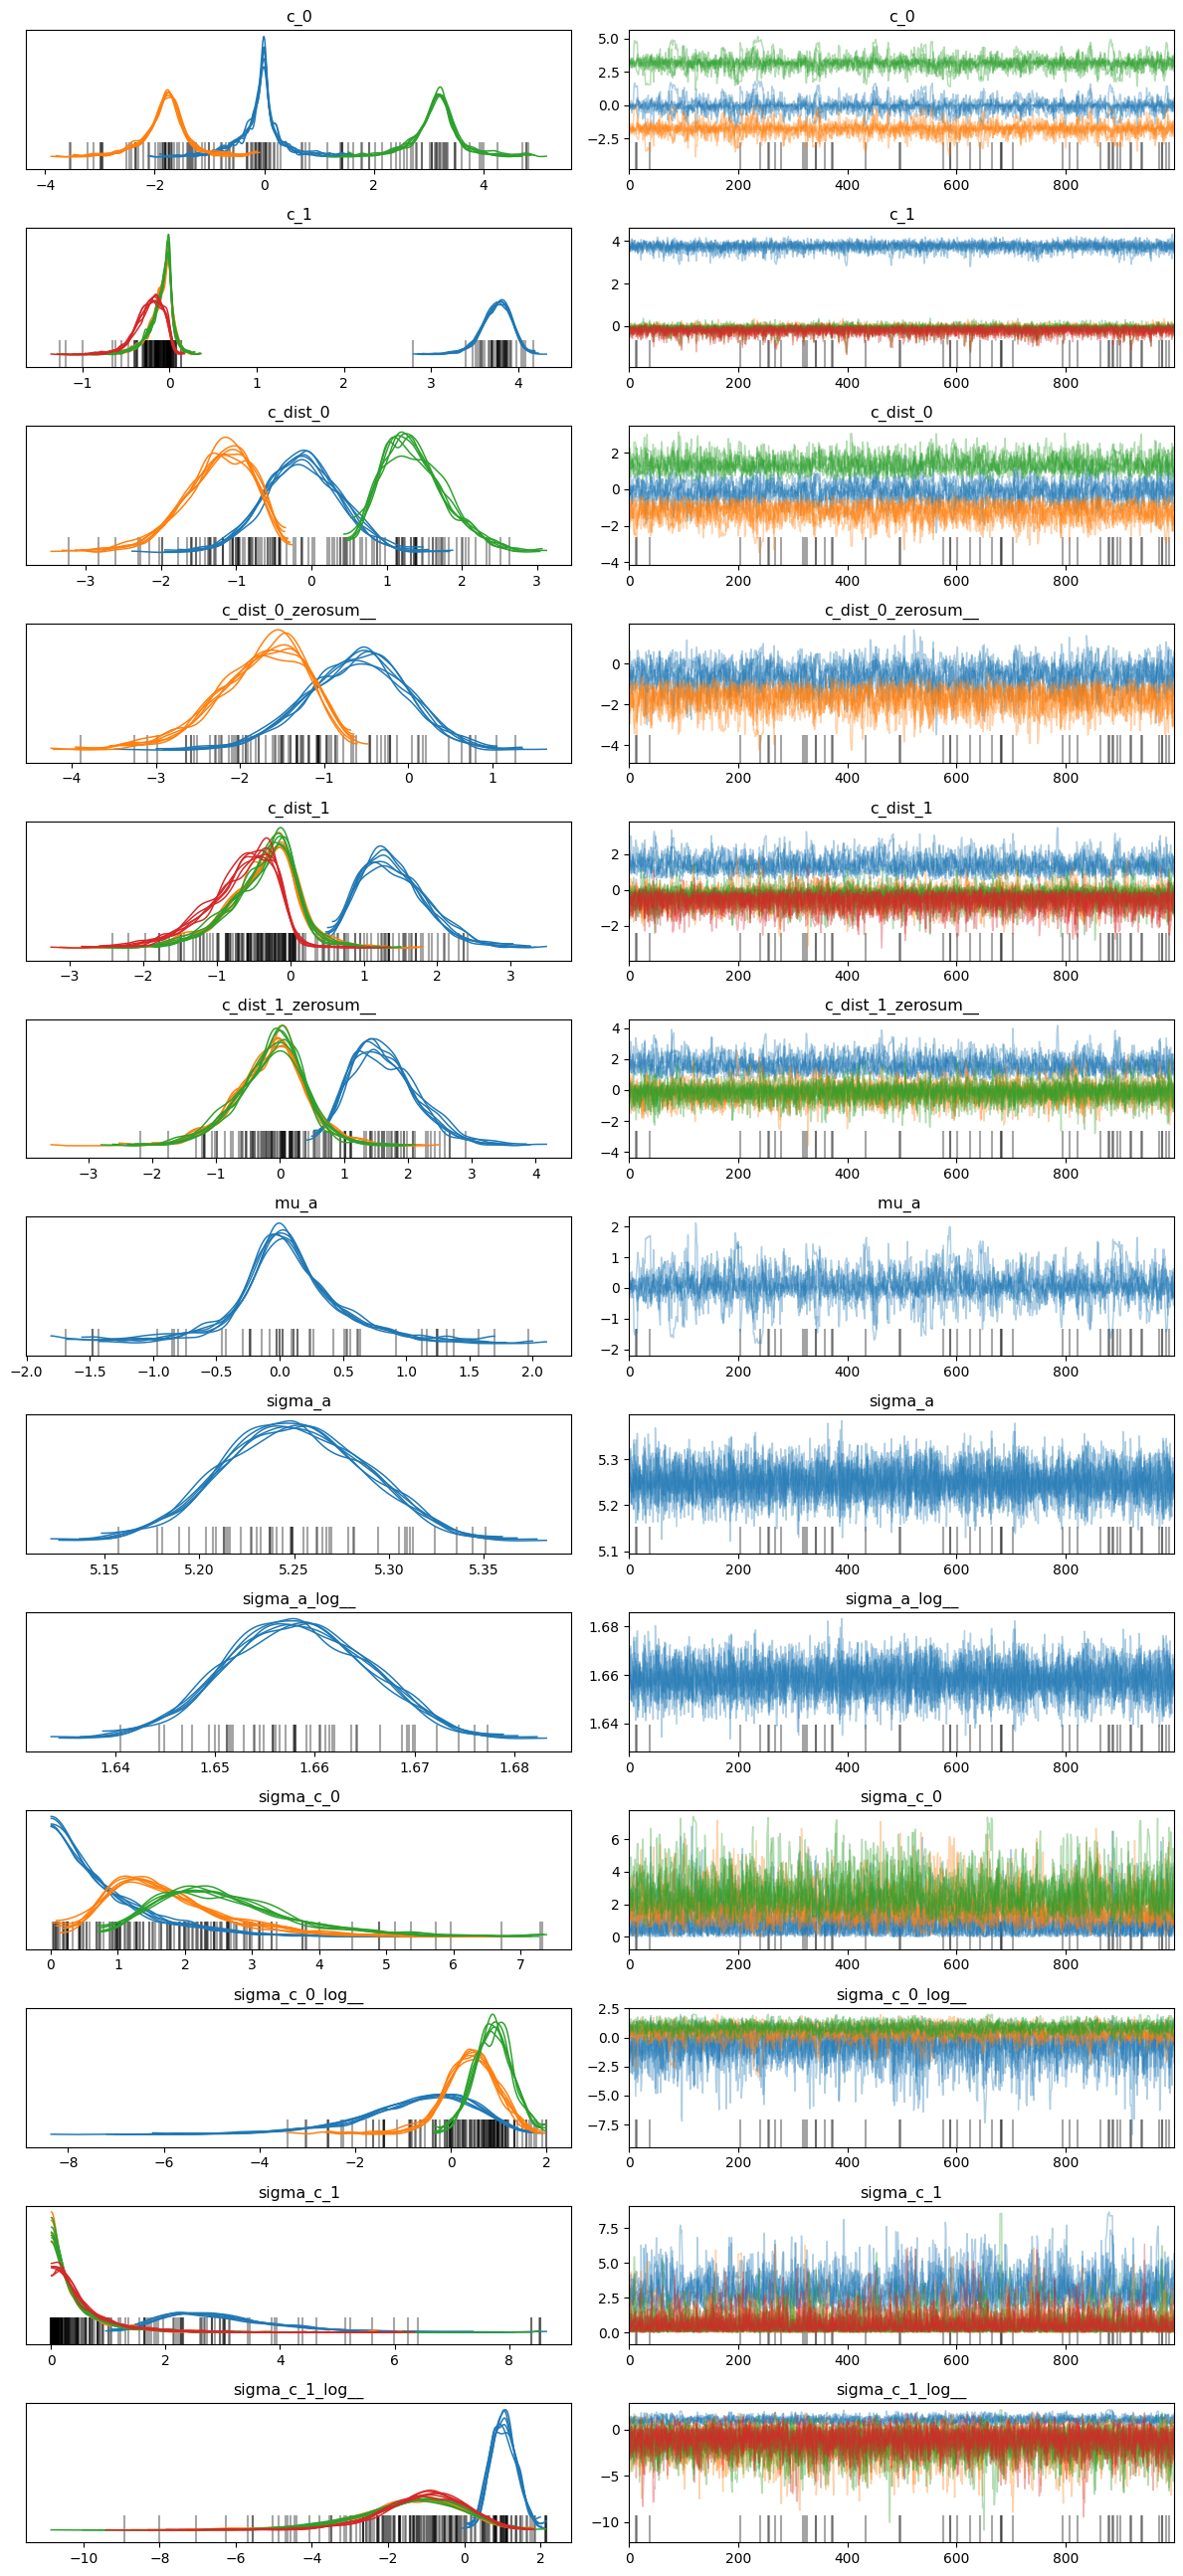

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
c_0[0]                -0.07  0.44   -1.00     0.86       0.01     0.01   
c_0[1]                -1.79  0.45   -2.77    -0.90       0.01     0.01   
c_0[2]                 3.15  0.45    2.22     4.09       0.01     0.01   
c_1[0]                 3.75  0.18    3.40     4.06       0.00     0.00   
c_1[1]                -0.11  0.15   -0.41     0.15       0.00     0.00   
c_1[2]                -0.10  0.15   -0.43     0.13       0.00     0.00   
c_1[3]                -0.23  0.17   -0.55     0.02       0.00     0.00   
c_dist_0[0]           -0.12  0.51   -1.11     0.80       0.01     0.01   
c_dist_0[1]           -1.24  0.47   -2.11    -0.46       0.01     0.01   
c_dist_0[2]            1.36  0.43    0.61     2.19       0.01     0.01   
c_dist_0_zerosum__[0] -0.62  0.60   -1.78     0.49       0.02     0.01   
c_dist_0_zerosum__[1] -1.74  0.55   -2.78    -0.82       0.01     0.01   
c_dist_1[0]            1.40  0.46    0.58     2.23       0.01     0.01   
c_dist_1[1]           -0.37  0.48   -1.43     0.44       0.01     0.01   
c_dist_1[2]           -0.36  0.47   -1.42     0.36       0.01     0.01   
c_dist_1[3]           -0.67  0.49   -1.65     0.04       0.01     0.01   
c_dist_1_zerosum__[0]  1.62  0.53    0.73     2.60       0.01     0.01   
c_dist_1_zerosum__[1] -0.14  0.57   -1.31     0.88       0.01     0.01   
c_dist_1_zerosum__[2] -0.14  0.55   -1.21     0.89       0.01     0.01   
mu_a                   0.06  0.46   -0.90     1.00       0.02     0.01   
sigma_a                5.25  0.04    5.18     5.32       0.00     0.00   
sigma_a_log__          1.66  0.01    1.65     1.67       0.00     0.00   
sigma_c_0[0]           0.84  0.82    0.00     2.33       0.02     0.01   
sigma_c_0[1]           1.74  0.95    0.29     3.66       0.02     0.02   
sigma_c_0[2]           2.61  1.07    0.87     4.58       0.03     0.02   
sigma_c_0_log__[0]    -0.76  1.29   -3.24     1.26       0.03     0.02   
sigma_c_0_log__[1]     0.40  0.61   -0.59     1.52       0.02     0.02   
sigma_c_0_log__[2]     0.88  0.40    0.09     1.62       0.01     0.01   
sigma_c_1[0]           3.00  1.09    1.29     5.01       0.03     0.02   
sigma_c_1[1]           0.48  0.62    0.00     1.51       0.01     0.01   
sigma_c_1[2]           0.49  0.63    0.00     1.53       0.01     0.01   
sigma_c_1[3]           0.56  0.62    0.00     1.64       0.01     0.01   
sigma_c_1_log__[0]     1.04  0.35    0.39     1.67       0.01     0.01   
sigma_c_1_log__[1]    -1.46  1.41   -4.18     0.93       0.03     0.02   
sigma_c_1_log__[2]    -1.43  1.39   -3.92     1.13       0.03     0.02   
sigma_c_1_log__[3]    -1.12  1.19   -3.35     0.91       0.02     0.02   

                       ess_bulk  ess_tail  r_hat  
c_0[0]                  1064.55   1140.13    1.0  
c_0[1]                  1173.62   1051.48    1.0  
c_0[2]                  1103.07   1095.40    1.0  
c_1[0]                  3191.19   3258.47    1.0  
c_1[1]                  2648.63   2843.03    1.0  
c_1[2]                  2644.48   3247.29    1.0  
c_1[3]                  2436.85   2811.77    1.0  
c_dist_0[0]             1396.44   1667.91    1.0  
c_dist_0[1]             1857.95   1534.04    1.0  
c_dist_0[2]             1736.87   2347.15    1.0  
c_dist_0_zerosum__[0]   1401.59   1616.97    1.0  
c_dist_0_zerosum__[1]   1822.05   1745.14    1.0  
c_dist_1[0]             1801.71   2093.21    1.0  
c_dist_1[1]             3079.84   2857.60    1.0  
c_dist_1[2]             3149.35   3385.76    1.0  
c_dist_1[3]             3196.27   2866.71    1.0  
c_dist_1_zerosum__[0]   1871.78   2299.86    1.0  
c_dist_1_zerosum__[1]   3121.17   2857.79    1.0  
c_dist_1_zerosum__[2]   3279.41   3443.90    1.0  
mu_a                    1077.75   1169.71    1.0  
sigma_a                 7557.96   4408.72    1.0  
sigma_a_log__           7557.96   4408.72    1.0  
sigma_c_0[0]            2550.17   2737.18    1.0  
sigma_c_0[1]            1332.01   1053.38    1.0  
sigma_c_0

In [81]:
trace = run_model(multi_layer_model)
analyze(trace)
az.summary(trace, round_to=2)

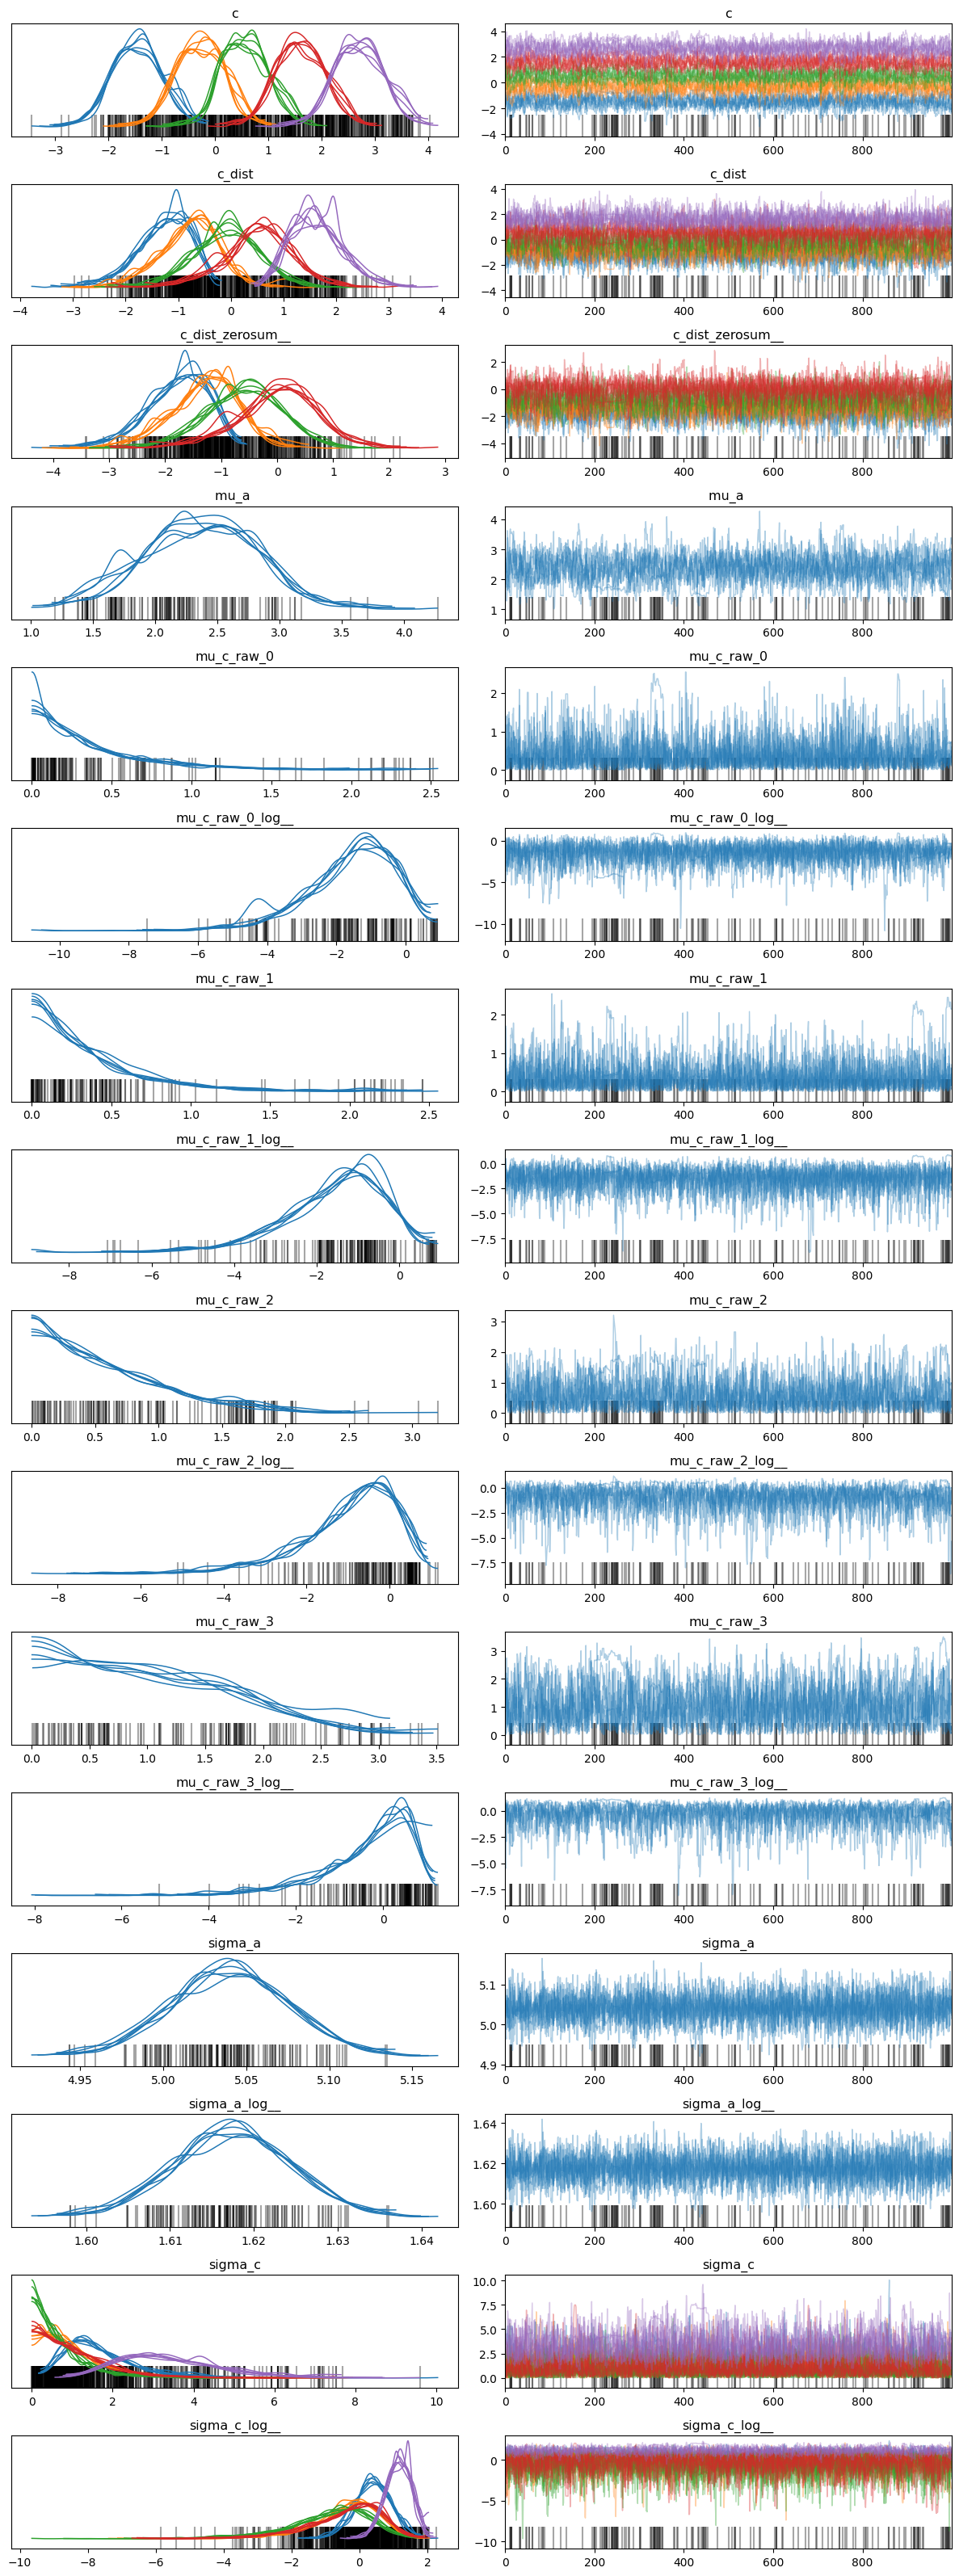

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
c[0]                -1.46  0.48   -2.30    -0.54       0.01     0.01   
c[1]                -0.28  0.47   -1.10     0.62       0.01     0.01   
c[2]                 0.56  0.46   -0.21     1.47       0.01     0.01   
c[3]                 1.60  0.47    0.77     2.50       0.01     0.01   
c[4]                 2.70  0.48    1.83     3.60       0.02     0.01   
c_dist[0]           -1.28  0.52   -2.25    -0.39       0.01     0.01   
c_dist[1]           -0.78  0.58   -1.92     0.27       0.02     0.01   
c_dist[2]           -0.09  0.64   -1.28     1.15       0.01     0.01   
c_dist[3]            0.51  0.69   -0.88     1.75       0.02     0.01   
c_dist[4]            1.64  0.51    0.70     2.56       0.01     0.01   
c_dist_zerosum__[0] -1.78  0.57   -2.82    -0.78       0.01     0.01   
c_dist_zerosum__[1] -1.28  0.63   -2.48    -0.08       0.02     0.01   
c_dist_zerosum__[2] -0.60  0.70   -1.86     0.77       0.01     0.01   
c_dist_zerosum__[3]  0.00  0.75   -1.46     1.43       0.02     0.02   
mu_a                 2.37  0.46    1.43     3.15       0.01     0.01   
mu_c_raw_0           0.38  0.40    0.00     1.12       0.01     0.01   
mu_c_raw_0_log__    -1.57  1.31   -4.13     0.54       0.03     0.03   
mu_c_raw_1           0.38  0.38    0.00     1.04       0.01     0.01   
mu_c_raw_1_log__    -1.55  1.25   -3.99     0.44       0.03     0.02   
mu_c_raw_2           0.61  0.50    0.00     1.58       0.02     0.01   
mu_c_raw_2_log__    -1.00  1.24   -3.33     0.80       0.03     0.02   
mu_c_raw_3           1.06  0.74    0.00     2.35       0.03     0.02   
mu_c_raw_3_log__    -0.33  1.10   -2.31     1.19       0.03     0.02   
sigma_a              5.04  0.04    4.97     5.11       0.00     0.00   
sigma_a_log__        1.62  0.01    1.60     1.63       0.00     0.00   
sigma_c[0]           1.71  0.95    0.30     3.49       0.03     0.02   
sigma_c[1]           0.99  0.81    0.00     2.40       0.02     0.01   
sigma_c[2]           0.72  0.71    0.00     1.97       0.01     0.01   
sigma_c[3]           1.05  0.93    0.00     2.61       0.02     0.01   
sigma_c[4]           3.39  1.29    1.26     5.87       0.04     0.03   
sigma_c_log__[0]     0.39  0.55   -0.64     1.41       0.02     0.01   
sigma_c_log__[1]    -0.41  1.05   -2.30     1.41       0.03     0.02   
sigma_c_log__[2]    -0.90  1.27   -3.28     1.20       0.02     0.02   
sigma_c_log__[3]    -0.44  1.18   -2.66     1.42       0.03     0.02   
sigma_c_log__[4]     1.15  0.39    0.40     1.84       0.01     0.01   

                     ess_bulk  ess_tail  r_hat  
c[0]                  1042.13    863.24   1.01  
c[1]                  1031.27   1390.04   1.01  
c[2]                   975.40    821.73   1.01  
c[3]                  1061.30   1417.96   1.01  
c[4]                   997.92   1254.50   1.01  
c_dist[0]             2289.70   2625.81   1.00  
c_dist[1]             1180.57    658.48   1.00  
c_dist[2]             1917.08   2409.15   1.01  
c_dist[3]             1303.40   1357.13   1.01  
c_dist[4]             2608.55   2920.39   1.01  
c_dist_zerosum__[0]   2266.72   2666.51   1.01  
c_dist_zerosum__[1]   1289.26    561.03   1.00  
c_dist_zerosum__[2]   2199.75   2752.05   1.00  
c_dist_zerosum__[3]   1293.34   1511.58   1.01  
mu_a                   990.14    827.14   1.01  
mu_c_raw_0            1565.91    578.03   1.00  
mu_c_raw_0_log__      1565.91    578.03   1.00  
mu_c_raw_1            2006.51   1120.75   1.00  
mu_c_raw_1_log__      2006.51   1120.75   1.00  
mu_c_raw_2            1096.38    841.73   1.00  
mu_c_raw_2_log__      1096.38    841.73   1.00  
mu_c_raw_3             824.51    331.97   1.01  
mu_c_raw_3_log__       824.51    331.97   1.01  
sigma_a               3082.36   2609.40   1.00  
sigma_a_log__         3082.36   2609.40   1.00  
sigma_c[0]            1136.80   1068.48   1.00  
sigma_c[1]            1826.80   2181.76   1.00  
sigma_c[2]            3376.66   2883.46   1.00  
sigma_c

In [27]:
analyze(trace)
az.summary(trace, round_to=2)

# First Try

In [92]:
with pm.Model() as model0c:
    """
    set the cons to 0
    
    """
    assert type(n_contributers0) is int, "only one level is possible"
    contributer_data_idx = pm.ConstantData(
        "contributer_data_idx", contributers0, dims="obs_id"
    )
    # datam = pm.ConstantData("data_idx", data0, dims="obs_id")

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    a_sigma = pm.Exponential("a_sigma", 1)

    # contributions
    con_sigmas = pm.Exponential("con_sigmas", 1, shape=n_contributers0)
    # cons_raw = pm.Normal("cons", mu=0, sigma = con_sigmas, shape=n_contributers0-1)
    cons_raw = [
        pm.Normal(f"cons_{i}", mu=0, sigma=con_sigmas, shape=1)
        for i in range(n_contributers0 - 1)
    ]
    """
    cons = [ -pt.sum(cons_raw, axis=0)
            if i == n_contributers0 else cons_raw[i]
            for i in range(n_contributers0)
            ]"""
    # cr = [cons_raw[i] for i in range(n_contributers0-1)]+[-pt.tensor.sum(cons_raw, axis=0)]
    # cons = pytensor.tensor.stacklists([cons_raw, -pt.tensor.sum(cons_raw, axis=0)]) # they need to have the same dimensions
    # cons = pytensor.tensor.stacklists(cons_raw +[-pt.tensor.sum(cons_raw)])
    cons = pytensor.tensor.stacklists(
        cons_raw + [-pt.tensor.sum(pytensor.tensor.stacklists(cons_raw))]
    )

    # expected value
    # y_hat = pm.Deterministic("y_hat", a_mu + cons[contributer_data_idx], dims = "obs_id") #one dimension for every datapoint
    y_hat = cons[contributer_data_idx]
    # Data
    value = pm.Normal("value", mu=y_hat, sigma=a_sigma, observed=data0)

c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


TypeError: Only tensors with the same number of dimensions can be joined. Input ndims were: [2, 2, 2, 1].

In [10]:
with pm.Model() as model1:
    """split sigmas via dirichlet distribution
    --> does not converge"""
    assert type(n_contributers0) is int, "only one level is possible"
    contributer_data_idx = pm.Data("contributer_data_idx", contributers0, dims="obs_id")
    # datam = pm.ConstantData("data_idx", data0, dims="obs_id")

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    a_sigma = pm.Exponential("a_sigma", 1)

    # contributions
    con_sigmas = pm.Exponential("con_sigmas", 1, shape=n_contributers0)
    con_mu = pm.Dirichlet(
        "con_mu_raw",
        1 / n_contributers0 * pm.math.ones(n_contributers0),
        shape=n_contributers0,
    )  # Dirichlet allows only positive numbers --> factor is needed
    conf_factor = pm.Exponential("factor", 1)

    con_mu = pm.Deterministic("con_mu", conf_factor * con_mu)

    cons = pm.Normal("cons", mu=con_mu, sigma=con_sigmas, shape=n_contributers0)

    # expected value
    # y_hat = pm.Deterministic("y_hat", a_mu + cons[contributer_data_idx]) #one dimension for every datapoint
    y_hat = a_mu + cons[contributer_data_idx]
    # Data
    value = pm.Normal("value", mu=y_hat, sigma=a_sigma, observed=data0)

In [39]:
trace = run_model(model0c)
analyze(trace)

start compilation


ValueError: Alloc static input type and target shape are incompatible: Vector(int8, shape=(4,)) vs (3,)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
a_sigma              5.17  0.02    5.13     5.21       0.00     0.00   
a_sigma_log__        1.64  0.00    1.64     1.65       0.00     0.00   
con_sigmas[0]        0.40  0.51    0.00     1.32       0.01     0.01   
con_sigmas[1]        0.43  0.53    0.01     1.35       0.01     0.01   
con_sigmas[2]        0.39  0.53    0.00     1.33       0.01     0.01   
con_sigmas[3]        2.87  1.09    1.23     4.80       0.02     0.02   
con_sigmas_log__[0] -1.61  1.27   -3.90     0.80       0.04     0.03   
con_sigmas_log__[1] -1.46  1.19   -3.53     0.96       0.04     0.03   
con_sigmas_log__[2] -1.71  1.33   -4.17     0.82       0.04     0.03   
con_sigmas_log__[3]  0.99  0.35    0.35     1.64       0.01     0.01   
cons[0]              0.06  0.06   -0.03     0.18       0.00     0.00   
cons[1]              0.09  0.06   -0.02     0.19       0.00     0.00   
cons[2]             -0.05  0.06   -0.16     0.05       0.00     0.00   
cons[3]              4.05  0.06    3.94     4.16       0.00     0.00   

                     ess_bulk  ess_tail  r_hat  
a_sigma               3082.05   2417.06    1.0  
a_sigma_log__         3082.05   2417.06    1.0  
con_sigmas[0]         1420.64    790.22    1.0  
con_sigmas[1]         1137.42    661.23    1.0  
con_sigmas[2]         1391.47    784.49    1.0  
con_sigmas[3]         2522.42   2910.38    1.0  
con_sigmas_log__[0]   1420.64    790.22    1.0  
con_sigmas_log__[1]   1137.42    661.23    1.0  
con_sigmas_log__[2]   1391.47    784.49    1.0  
con_sigmas_log__[3]   2522.42   2910.38    1.0  
cons[0]               2323.70   2788.08    1.0  
cons[1]               2549.54   2269.34    1.0  
cons[2]               2499.60   2602.07    1.0  
cons[3]               4051.75   3572.03    1.0

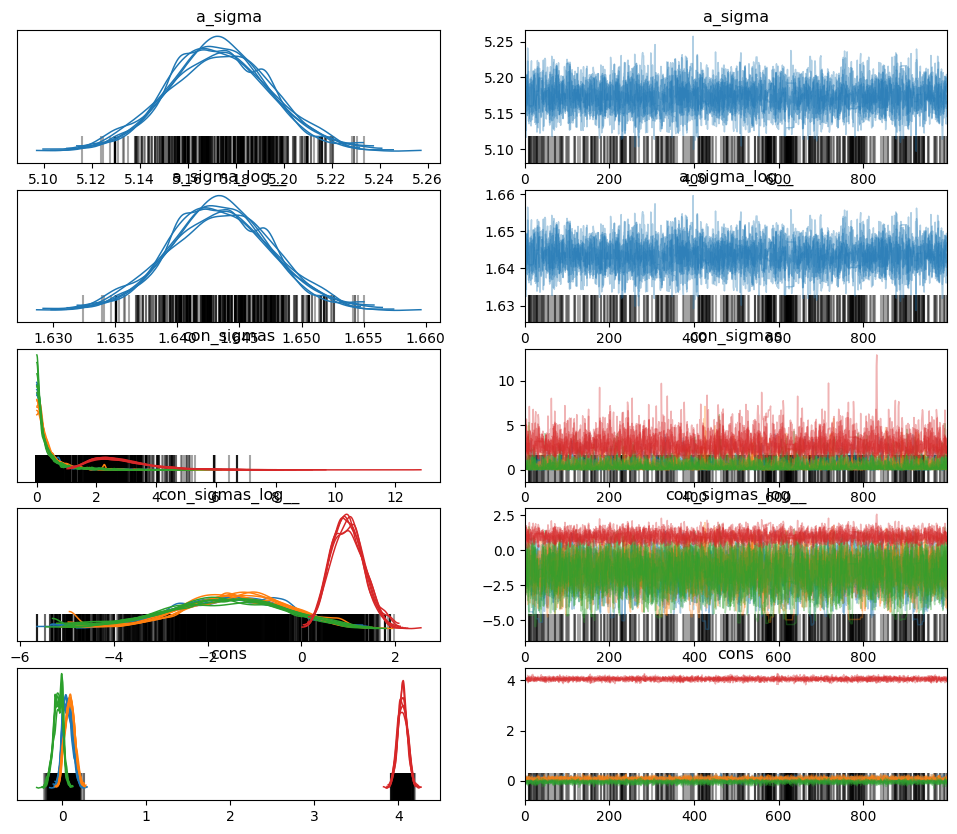

In [25]:
analyze(trace)

In [26]:
def get_dir(n):
    """return initializing value for dirichlet -> all values are 1/n as pytensor"""
    # return 1/n * np.ones(n)
    return 1 / (n) * pm.math.ones(n)  # maybe this can be optimized

In [84]:
with pm.Model() as model2:
    """
    Idea:
    * calculate sigma of the data
    * distribute it via the sums to all individual contributions
    """
    assert type(n_contributers) is int, "only one level is possible"
    contributer_data_idx = pm.Data("contributer_data_idx", contributers0, dims="obs_id")
    sigmax = pm.Data("sigmax", np.std(data0))

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    sigmas = pm.Dirichlet(
        "sigmas", get_dir(n_contributers + 1), shape=n_contributers + 1
    )

    # contributions
    con_mu = pm.Dirichlet(
        "con_mu_raw", get_dir(n_contributers), shape=n_contributers
    )  # Dirichlet allows only positive numbers --> factor is needed
    conf_factor = pm.Exponential("factor", 1)

    con_mu = pm.Deterministic("con_mu", conf_factor * con_mu)

    cons = pm.Normal("cons", mu=con_mu, sigma=sigmas[1:] ** 0.5, shape=n_contributers)

    # expected value
    y_hat = a_mu + cons[contributer_data_idx]

    # Data
    value = pm.Normal("value", mu=y_hat, sigma=sigmas[0] ** 0.5, observed=data0)

In [25]:
# Sigmas will be one big vector for all contributors.
# Therefore, indexing is needed to find the right values


def start(n_contributers, level):
    assert (
        0 <= level < len(n_contributers)
    ), f"level {level} not possible for {n_contributers}"
    return int(1 + np.sum(n_contributers[:level]))


def end(n_contributers, level):
    assert (
        0 <= level < len(n_contributers)
    ), f"level {level} not possible for {n_contributers}"
    return int(1 + np.sum(n_contributers[: (level + 1)]))

In [29]:
n_cons = int(1 + np.sum(n_contributers))
n_level = len(n_contributers)

In [30]:
with pm.Model() as mlmodel1:
    """
    multi-level model
    Idea:
    * calculate sigma of the data
    * distribute it via the sums to all individual contributions
    """
    assert type(n_contributers) is list, "only multi-levels are possible"

    contributer_data_idx = pm.Data(
        "contributer_data_idx",
        contributers,
        dims=("obs_id", "level"),
        shape=(n_samples, n_level),
    )

    data_idx = pm.Data(
        "data_idx",
        data,
        dims="obs_id",
    )
    # shape=n_samples)

    sigmax = pm.Data("sigmax", np.std(data))

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    sigmas_raw = pm.Dirichlet("sigmas_raw", get_dir(n_cons), shape=n_cons)
    sigmas = pm.Deterministic("sigmas", sigmax * sigmas_raw)

    # contributions
    # con_mu = pm.Dirichlet("con_mu_raw",get_dir(n_contributers), shape=n_contributers) # Dirichlet allows only positive numbers --> factor is needed
    con_mu_dir = [
        pm.Dirichlet(f"con_mu_raw_{i}", get_dir(n_cons), shape=n_cons)
        for i, n_cons in enumerate(n_contributers)
    ]

    con_factor = pm.Exponential("factor", 1, shape=n_level)

    con_mu = [
        pm.Deterministic(f"con_mu_{i}", con_factor[i] * con_mu_dir[i])
        for i in range(n_level)
    ]

    cons = [
        pm.Normal(
            f"cons_{i}",
            mu=con_mu[i],
            sigma=sigmas[start(n_contributers, i) : end(n_contributers, i)] ** 0.5,
            shape=n_contributers,
        )
        for i in range(n_level)
    ]

    # expected value
    y_hat = a_mu + pt.tensor.sum(
        pt.tensor.concatenate(
            [cons[i][contributer_data_idx[:, i]] for i in range(n_level)], axis=1
        )
    )

    # Data
    value = pm.Normal("value", mu=y_hat, sigma=sigmas[0] ** 0.5, observed=data_idx)

try a [reparametrization](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) via
```
    # Before:
    # a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Transformed:
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=n_counties)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)
```


In [23]:
n_level = n_layers
n_cons

In [27]:
with pm.Model() as mlmodel2:
    """
    multi-level model
    Idea:
    * calculate sigma of the data
    * distribute it via the sums to all individual contributions

    # Before:
    # a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Transformed:
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=n_counties)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)
    """
    assert type(n_contributers) is list, "only multi-levels are possible"

    contributer_data_idx = pm.Data(
        "contributer_data_idx",
        contributers,
        dims=("obs_id", "level"),
        shape=(n_samples, n_level),
    )

    data_idx = pm.Data(
        "data_idx",
        data,
        dims="obs_id",
    )
    # shape=n_samples)

    sigmax = pm.Data("sigmax", np.std(data))

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    sigmas_raw = pm.Dirichlet("sigmas_raw", get_dir(n_cons), shape=n_cons)
    sigmas = pm.Deterministic("sigmas", sigmax * sigmas_raw)

    # contributions
    # con_mu = pm.Dirichlet("con_mu_raw",get_dir(n_contributers), shape=n_contributers) # Dirichlet allows only positive numbers --> factor is needed
    con_mu_dir = [
        pm.Dirichlet(f"con_mu_dir_{i}", get_dir(n_cons), shape=n_cons)
        for i, n_cons in enumerate(n_contributers)
    ]

    con_factor = pm.Exponential("factor", 1, shape=n_level)

    con_mu = [
        pm.Deterministic(f"con_mu_{i}", con_factor[i] * con_mu_dir[i])
        for i in range(n_level)
    ]
    """
    cons = [
        pm.Normal(f"cons_{i}",
                      mu=con_mu[i],
                      sigma = sigmas[start(n_contributers, i):end(n_contributers, i)]**0.5,
                      shape=n_contributers) 
                      for i in range(n_level)
                      ]
    """
    # reparametrization
    cons_offset = [
        pm.Normal(f"cons_offset_{i}", mu=0, sigma=1, shape=n_contributers)
        for i in range(n_level)
    ]
    cons = [
        pm.Deterministic(
            f"cons_{i}",
            con_mu[i]
            + cons_offset[i]
            * sigmas[start(n_contributers, i) : end(n_contributers, i)] ** 0.5,
        )
        for i in range(n_level)
    ]
    # expected value
    y_hat = a_mu + pt.tensor.sum(
        pt.tensor.concatenate(
            [cons[i][contributer_data_idx[:, i]] for i in range(n_level)], axis=1
        )
    )

    # Data
    value = pm.Normal("value", mu=y_hat, sigma=sigmas[0] ** 0.5, observed=data_idx)

NameError: name 'n_cons' is not defined

[Profiling](https://www.pymc.io/projects/examples/en/latest/howto/profiling.html)

In [47]:
bdata

array([3, 2, 2, ..., 1, 4, 2])

In [199]:
mlmodel2.profile(mlmodel2.logp()).summary()

Function profiling
  Message: c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\pytensorf.py:1039
  Time in 1000 calls to Function.__call__: 5.761102e+02s
  Time in Function.vm.__call__: 576.0453123999432s (99.989%)
  Time in thunks: 575.9412937998313s (99.971%)
  Total compilation time: 4.372608e-01s
    Number of Apply nodes: 106
    PyTensor rewrite time: 4.296800e-01s
       PyTensor validate time: 8.765600e-03s
    PyTensor Linker time (includes C, CUDA code generation/compiling): 0.0028562000006786548s
       C-cache preloading 0.000000e+00s
       Import time 0.000000e+00s
       Node make_thunk time 1.238600e-03s
           Node Composite{...}(Sum{axes=None}.0, Max{axes=None}.0, 2.0, Max{axes=None}.0, Sum{axes=None}.0, 5.0, Max{axes=None}.0, Sum{axes=None}.0, -0.22579138462016424, Sum{axes=None}.0, Sum{axes=None}.0, Sum{axes=None}.0, Sum{axes=None}.0, DropDims{axis=0}.0, -inf, Sum{axes=None}.0, Any{axis=0}.0, Any{axis=0}.0, DropDims{axis=0}.0, Sum{ax

Next idea: go back to the initial approach with n-1 dimensions via
```
cons_raw = pm.Normal("cons_raw", 0, 1, shape=n-1)
cons = [
    -pt.tensor.sum(pt.tensor.concatenate(cons_raw)) if i == n-1 else
        pm.Deterministic(f"cons{i}", cons_raw[i])
    for i in range(n)
]
```
Loop fusion failes???

https://discourse.pymc.io/t/panel-model-fitting-issue/9147

In [198]:
print("start compilation")
compiled_model = nutpie.compile_pymc_model(mlmodel2)
print("model is compiled")
trace_nutpie = nutpie.sample(
    compiled_model,
    tune=1000,
    draws=4000,
    chains=12,
)

start compilation


c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1027: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(


model is compiled


In [194]:
az.summary(trace_nutpie, round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
a_mu                     -0.11  0.02   -0.16    -0.06       0.00     0.00   
con_mu[0]                 0.01  0.01    0.00     0.04       0.00     0.00   
con_mu[1]                 0.20  0.03    0.15     0.26       0.00     0.00   
con_mu[2]                 0.18  0.03    0.12     0.24       0.00     0.00   
con_mu[3]                 4.07  0.03    4.01     4.13       0.00     0.00   
con_mu_raw[0]             0.00  0.00    0.00     0.01       0.00     0.00   
con_mu_raw[1]             0.05  0.01    0.03     0.06       0.00     0.00   
con_mu_raw[2]             0.04  0.01    0.03     0.05       0.00     0.00   
con_mu_raw[3]             0.91  0.01    0.88     0.93       0.00     0.00   
con_mu_raw_simplex__[0]  -4.72  2.33   -8.88    -1.69       0.49     0.35   
con_mu_raw_simplex__[1]   0.63  0.77   -0.36     2.03       0.16     0.11   
con_mu_raw_simplex__[2]   0.47  0.76   -0.50     1.91       0.16     0.11   
cons[0]                   0.01  0.01   -0.00     0.04       0.00     0.00   
cons[1]                   0.20  0.03    0.15     0.26       0.00     0.00   
cons[2]                   0.18  0.03    0.12     0.24       0.00     0.00   
cons[3]                   4.07  0.03    4.01     4.13       0.00     0.00   
factor                    4.46  0.09    4.29     4.64       0.01     0.01   
factor_log__              1.49  0.02    1.46     1.53       0.00     0.00   
sigmas[0]                 1.00  0.00    1.00     1.00       0.00     0.00   
sigmas[1]                 0.00  0.00    0.00     0.00       0.00     0.00   
sigmas[2]                 0.00  0.00    0.00     0.00       0.00     0.00   
sigmas[3]                 0.00  0.00    0.00     0.00       0.00     0.00   
sigmas[4]                 0.00  0.00    0.00     0.00       0.00     0.00   
sigmas_simplex__[0]      12.10  0.98   10.21    13.74       0.09     0.06   
sigmas_simplex__[1]      -3.69  2.91   -9.08     1.64       0.34     0.24   
sigmas_simplex__[2]      -3.25  2.36   -8.13     0.22       0.37     0.32   
sigmas_simplex__[3]      -2.93  2.10   -7.24     0.38       0.28     0.24   

                         ess_bulk  ess_tail  r_hat  
a_mu                        77.41     84.00   1.10  
con_mu[0]                   22.83     65.42   1.51  
con_mu[1]                  116.04    305.22   1.10  
con_mu[2]                  102.49    109.21   1.08  
con_mu[3]                   93.51    118.32   1.08  
con_mu_raw[0]               22.82     65.42   1.51  
con_mu_raw[1]              128.15    746.65   1.09  
con_mu_raw[2]              108.57    130.81   1.07  
con_mu_raw[3]               69.30     73.68   1.11  
con_mu_raw_simplex__[0]     22.81     63.83   1.51  
con_mu_raw_simplex__[1]     23.59     88.85   1.48  
con_mu_raw_simplex__[2]     22.86     56.18   1.51  
cons[0]                     23.21     18.28   1.48  
cons[1]                    115.28    297.63   1.10  
cons[2]                    102.80    109.63   1.08  
cons[3]                     95.07    118.17   1.08  
factor                      76.74     75.94   1.16  
factor_log__                76.74     75.94   1.16  
sigmas[0]                  182.78   1526.60   1.04  
sigmas[1]                   89.91    147.06   1.08  
sigmas[2]                   44.14     18.52   1.18  
sigmas[3]                   55.07     21.07   1.14  
sigmas[4]                  403.97    190.56   1.05  
sigmas_simplex__[0]        131.06    836.48   1.06  
sigmas_simplex__[1]         52.85     18.27   1.15  
sigmas_simplex__[2]         45.37     28.63   1.19  
sigmas_simplex__[3]         65.13     30.33   1.13

array([[<Axes: title={'center': 'a_mu'}>,
        <Axes: title={'center': 'a_mu'}>],
       [<Axes: title={'center': 'con_mu'}>,
        <Axes: title={'center': 'con_mu'}>],
       [<Axes: title={'center': 'con_mu_raw'}>,
        <Axes: title={'center': 'con_mu_raw'}>],
       [<Axes: title={'center': 'con_mu_raw_simplex__'}>,
        <Axes: title={'center': 'con_mu_raw_simplex__'}>],
       [<Axes: title={'center': 'cons'}>,
        <Axes: title={'center': 'cons'}>],
       [<Axes: title={'center': 'factor'}>,
        <Axes: title={'center': 'factor'}>],
       [<Axes: title={'center': 'factor_log__'}>,
        <Axes: title={'center': 'factor_log__'}>],
       [<Axes: title={'center': 'sigmas'}>,
        <Axes: title={'center': 'sigmas'}>],
       [<Axes: title={'center': 'sigmas_simplex__'}>,
        <Axes: title={'center': 'sigmas_simplex__'}>]], dtype=object)

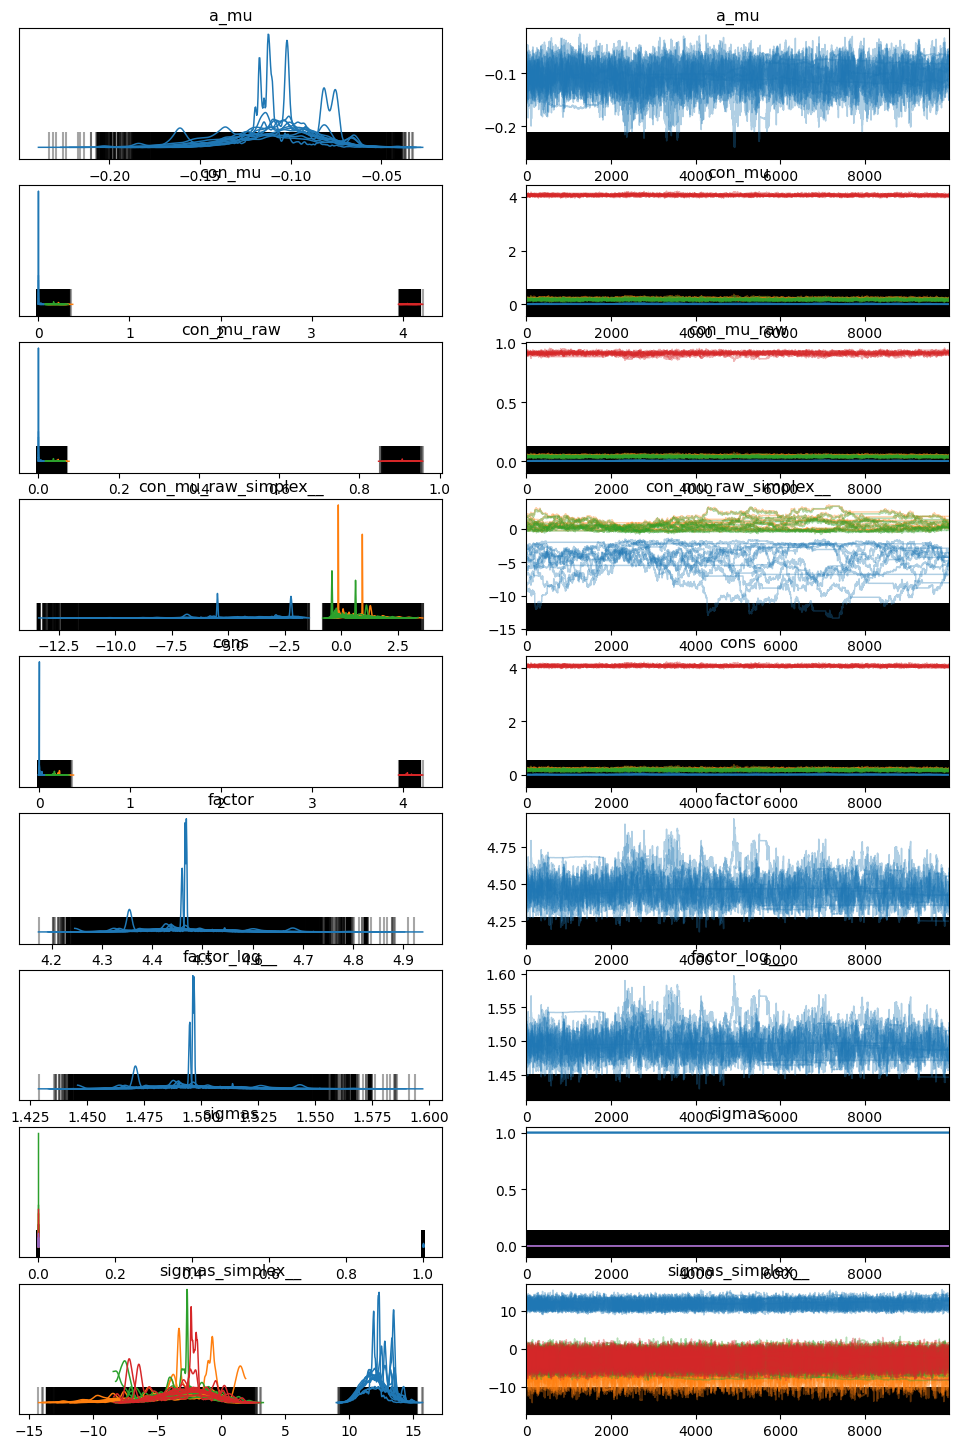

In [195]:
az.plot_trace(
    trace_nutpie,
    compact="true",
    chain_prop={"ls": "-"},
)

# Model Selection via PPC
* see [Prior and Posterior Predictive Checks](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html)
* maybe [BART / Bayesian additive regression trees](https://www.pymc.io/projects/bart/en/latest/examples/bart_introduction.html) can enhance the modeling

In [19]:
with model0:
    idata = pm.sample_prior_predictive(draws=50)

Sampling: [a_mu, a_sigma, con_sigmas, cons, value]


In [21]:
az.plot_ppc(idata.posterior, num_pp_samples=100);

AttributeError: 'InferenceData' object has no attribute 'posterior'

In [22]:
idata.prior

<xarray.Dataset> Size: 3kB
Dimensions:           (chain: 1, draw: 50, con_sigmas_dim_0: 2, cons_dim_0: 2)
Coordinates:
  * chain             (chain) int32 4B 0
  * draw              (draw) int32 200B 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * con_sigmas_dim_0  (con_sigmas_dim_0) int32 8B 0 1
  * cons_dim_0        (cons_dim_0) int32 8B 0 1
Data variables:
    a_mu              (chain, draw) float64 400B -3.888 8.243 ... 1.139 10.28
    a_sigma           (chain, draw) float64 400B 0.3543 0.7871 ... 1.927 0.645
    con_sigmas        (chain, draw, con_sigmas_dim_0) float64 800B 0.8964 ......
    cons              (chain, draw, cons_dim_0) float64 800B -0.07385 ... 0.4735
Attributes:
    created_at:                 2024-09-20T05:13:44.670094+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2